In [1]:
# 高维线性回归
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

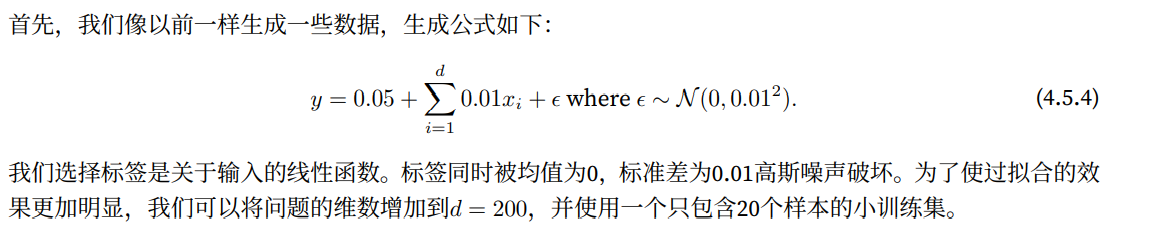

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [3]:
# 初始化函数模型
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [5]:
# 定义L2范数惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [6]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # ⼴播机制使l2_penalty(w)成为⼀个⻓度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                    d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 12.8472261428833


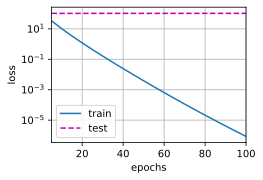

In [7]:
# 忽略正则化直接训练
train(lambd=0)

w的L2范数是： 0.3724144697189331


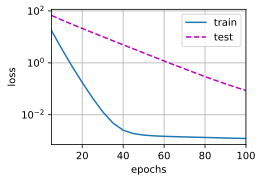

In [8]:
# 使⽤权重衰减
train(lambd=3)

In [9]:
# 简介实现
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                            (d2l.evaluate_loss(net, train_iter, loss),
                            d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 14.199109077453613


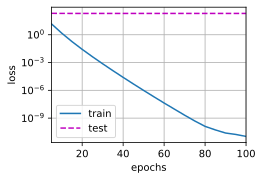

In [10]:
train_concise(0)

w的L2范数： 0.4023776352405548


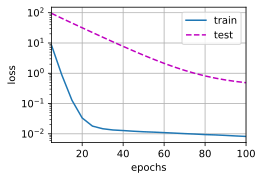

In [11]:
train_concise(3)

⼩结    
• 正则化是处理过拟合的常⽤⽅法：在训练集的损失函数中加⼊惩罚项，以降低学习到的模型的复杂度。   
• 保持模型简单的⼀个特别的选择是使⽤L2惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。   
• 权重衰减功能在深度学习框架的优化器中提供。   
• 在同⼀训练代码实现中，不同的参数集可以有不同的更新⾏为。

练习
1. 在本节的估计问题中使⽤λ的值进⾏实验。绘制训练和测试精度关于λ的函数。你观察到了什么？
2. 使⽤验证集来找到最佳值λ。它真的是最优值吗？这有关系吗？
3. 如果我们使⽤$∑_{i}|w_{i}|$作为我们选择的惩罚（L1正则化），那么更新⽅程会是什么样⼦？
4. 我们知道$||w||^2 = w^{T}w$。你能找到类似的矩阵⽅程吗（⻅ 2.3.10节 中的Frobenius范数）？
5. 回顾训练误差和泛化误差之间的关系。除了权重衰减、增加训练数据、使⽤适当复杂度的模型之外，你还能想出其他什么⽅法来处理过拟合？
6. 在⻉叶斯统计中，我们使⽤先验和似然的乘积，通过公式P(w | x) ∝ P(x | w)P(w)得到后验。如何得到带正则化的P(w)？

1. λ 增加的时候，即惩罚项在目标函数中的权重随之提高，体现在训练集上面精度会略微降低，在测试集上面训练的精度会提高，这是因为过程中的过拟合现象会随着 λ 的提升会有明显的改善，所以训练精度有减低，测试集上面精度上升。但也不是 λ 越大越好，当 λ 过大时，会对训练误差产生很严重的扰动。
2. 它是相对于这个训练集和测试机的最优值。如果数据集的大小改变，那么这个λ 值也会随之改变。不是最优的lambd，因为实际数据也不可能和验证集分布一样，但是是在验证集上表现最好的，泛化性能因为会比较优秀。

In [2]:
# 3.
def l1_penalty(w):
    return torch.abs(w).sum()#sum(abs(w))

3.
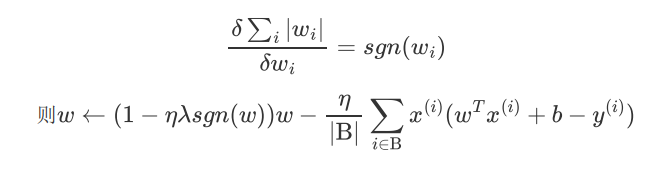

4. Frobenius范数相当于开方的$||w||^2$

5. Dropout，或者先用PCA处理减少一定的次要特征，或者加大数据量。

6. 私以为这里中文翻译有点奇怪，英文原文是：In Bayesian statistics we use the product of prior andlikelihood to arrive at a posterior via P(w∣x)∝P(x∣w)P(w) . How can you identify P(w) withregularization?翻译过来感觉应该是 P(w) 与 正则化(regularization) 的联系。那么可以解释为，优化w的过程其实是一个argmax后验概率P(w∣x)的过程
$$
\begin{gathered}
\operatorname{argmax} P(w \mid x) \Longleftrightarrow \operatorname{argmax} P(x \mid w) P(w) \Longleftrightarrow \operatorname{argmin} \sum-\ln P\left(x_{i} \mid w\right)-\ln P(w) \\
\text { 假设 } P(w) \text { 服从一定的分布, 化简出来就是正则化项了 } \\
\text { 例 : 若 } w \sim N\left(0, \sigma^{2}\right), \text { 则 } P(w) \sim \exp \left(\frac{\left\|w_{i}\right\|_{2}}{2 \sigma^{2}}\right) \\
\text { 则 }-\ln P(w) \sim-\frac{\left\|w_{i}\right\|_{2}}{2 \sigma^{2}}, \text { 令 } \lambda=\frac{1}{2 \sigma^{2}}, \text { 则 }-\ln P(w) \sim \lambda\left\|w_{i}\right\|_{2}
\end{gathered}
$$

6. 同样的，还有一些很有趣的分布和他们的正则化项[参考链接](https://blog.csdn.net/qq_33638791/article/details/76039641?locationNum=1&fps=1)
- $\min _{w} E=\sum_{i=1}^{N}\left(y_{i}-f(x, w)\right)^{2}+\lambda\|w\|_{2}^{2}$
拟合误差符合0均值高斯分布，模型先验服从0均值高斯分布
- $\min _{w} E=\sum_{i=1}^{N}\left(y_{i}-f(x, w)\right)^{2}+\lambda|w-\mu|$
拟合误差符合 O均值高斯分布，模型先验服从均值为 $\mu$ 的拉普拉斯分布
- $\min _{w} E=\sum_{i=1}^{N}\left|y_{i}-f(x, w)\right|+\lambda\|w\|_{2}^{2}$
拟合误差符合 0均值拉普拉斯分布，模型先验服从均值为 $\mu$ 的高斯分布
- $\min _{w} E=\sum_{i=1}^{N}\left|y_{i}-f(x, w)\right|+\lambda|w|$
拟合误差符合 0均值拉普拉斯分布，模型先验服从0均值拉普拉斯分布